In [14]:
import spatioloji_s as sj
import numpy as pd
import pandas as pd
import psutil
import os
import matplotlib.pyplot as plt
import cv2

In [15]:
mem = psutil.virtual_memory()
print(f"Total memory available: {mem.total / 1024**3:.2f} GB")
cpus = os.cpu_count()
print(f"Total cpu cores available: {cpus}")
print(f"current work directory is {os.getcwd()}")

Total memory available: 251.40 GB
Total cpu cores available: 64
current work directory is /carc/scratch/projects/amitra2016502/spatioloji_s/example


In [16]:
# Load your spatioloji object
sp = sj.data.spatioloji.from_pickle('my_qc_output/data/filtered_spatioloji.pkl')



Loading spatioloji from: my_qc_output/data/filtered_spatioloji.pkl
✓ Loaded: 25,368 cells × 960 genes


In [17]:
# Normalize data
sj.processing.normalize_total(sp, target_sum=1e4, inplace=True)
sj.processing.log_transform(sp, layer='normalized_counts', inplace=True)

# Select highly variable genes
# # of HVG may be less than n_top_genes because we have other cut-off values to filter
sj.processing.highly_variable_genes(sp, n_top_genes=2000, inplace=True, min_disp=0, min_mean=0)

# scale data
sj.processing.scale(sp, layer='log_normalized', inplace=True)
    
# Dimensionality reduction
sj.processing.pca(sp, n_comps=50, inplace=True, zero_center=True, layer='scaled')
sj.processing.umap(sp, use_pca=True, inplace=True, n_neighbors=10, n_pcs=30)

# Clustering
sj.processing.leiden_clustering(sp, resolution=0.5, inplace=True, layer='normalized_counts')


Normalizing expression to target sum: 10,000
  Counts per cell - mean: 179, median: 140
  ✓ Normalized 25,368 cells × 960 genes
✓ Added layer 'normalized_counts' (dense, 185.8 MB)

Applying log transformation (base=e)
  ✓ Transformed 25,368 cells × 960 genes
✓ Added layer 'log_normalized' (dense, 185.8 MB)

Identifying highly variable genes (method=seurat)
  Using Seurat method (n_top_genes=2000)
  ✓ Selected 475 highly variable genes
    Mean expression range: 0.02 - 2.63

Scaling expression data (method: standard)
  Clipped values to [-10.0, 10.0]
  ✓ Scaled 25,368 cells × 960 genes
✓ Added layer 'scaled' (dense, 185.8 MB)

Computing PCA (n_comps=50)
  Using 475 highly variable genes
  Running PCA...
  ✓ PCA complete
    Variance explained by first 10 PCs: 13.9%
    Variance explained by all 50 PCs: 24.4%

UMAP (n_components=2, n_neighbors=10, min_dist=0.1)
  Using first 30 PCs as input
  Running UMAP...


/users/jiwang1/.conda/envs/spatioloji/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  ✓ UMAP complete

Leiden clustering (resolution=0.5, n_neighbors=15)
  Using 475 highly variable genes (out of 960 total)

Leiden clustering (resolution=0.5, n_neighbors=15)
  Computing PCA (n_pcs=50)...
    Variance explained: 65.9%
  Building k-NN graph...
  Running Leiden algorithm...
  ✓ Found 7 clusters
    Cluster sizes - min: 1326, max: 7835, mean: 3624.0


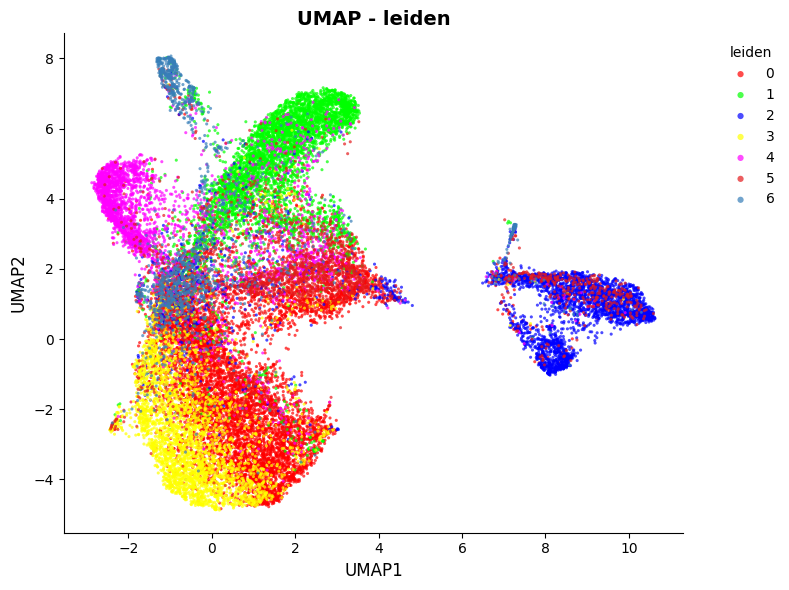

In [18]:
cluster_colors = {
    '0': '#FF0000',
    '1': '#00FF00', 
    '2': '#0000FF',  
    '3': '#FFFF00',  
    '4': '#FF00FF',
    '5': '#E41A1C',
    '6': '#377EB8'
}
sj.visualization.plot_umap_by_clusters(sp, 
                                       cluster_column='leiden',
                                       show=False,
                                       colors=cluster_colors)

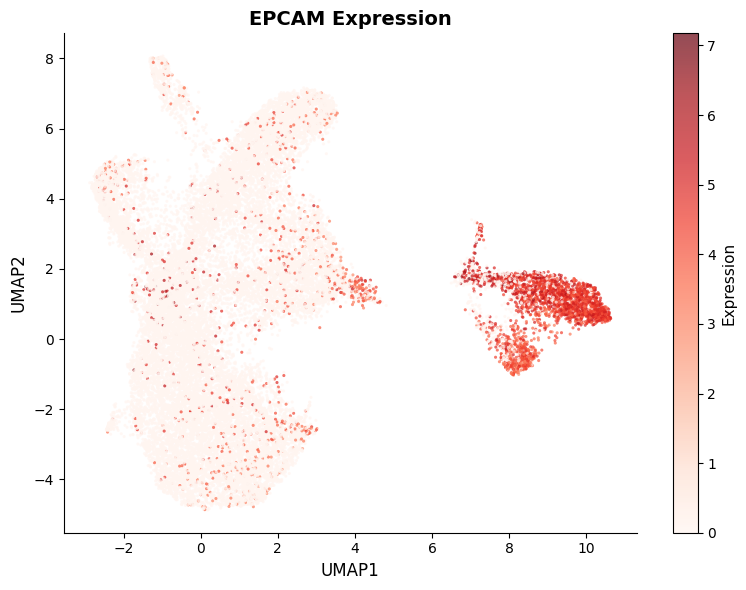

In [19]:
sj.visualization.plot_umap_by_gene(sp, gene_name='EPCAM', color_map='Reds',
                                   layer='log_normalized',
                                   show=False)

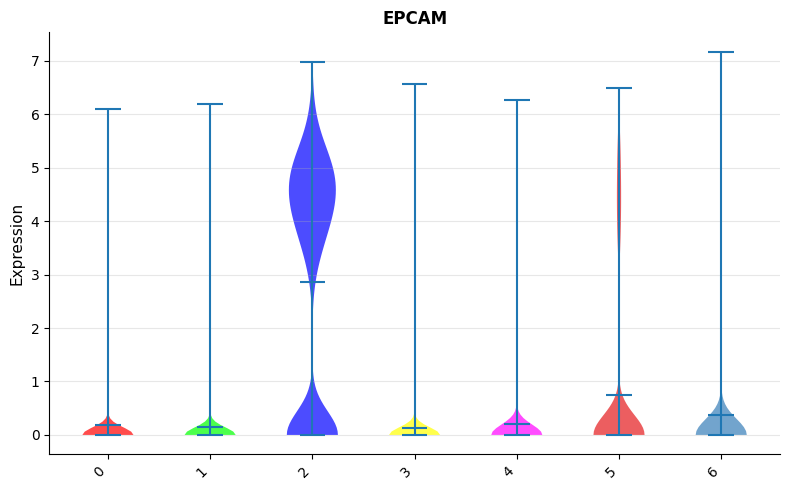

In [20]:
custom_order = [str(i) for i in range(len(sp._cell_meta.leiden.unique()))]
sj.visualization.plot_violin(sp, genes='EPCAM', group_by='leiden', layer='log_normalized',
                             colors=cluster_colors, group_order=custom_order, show=False)

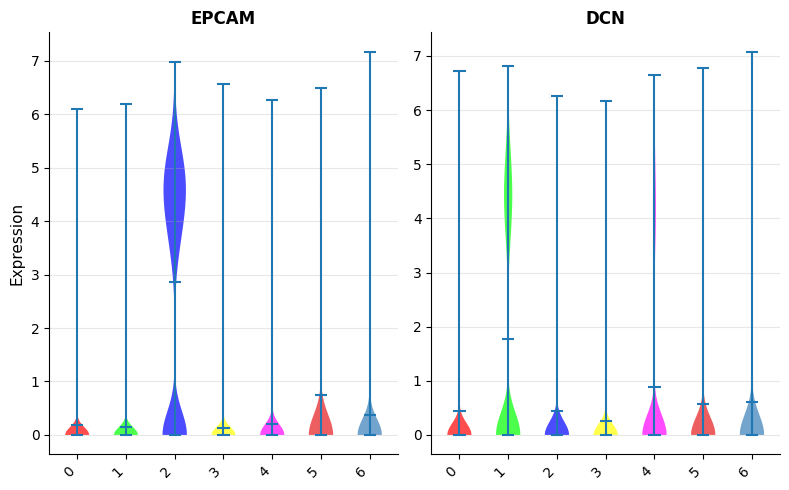

In [21]:
sj.visualization.plot_violin(sp, genes=['EPCAM', 'DCN'], group_by='leiden', layer='log_normalized',
                             colors=cluster_colors, group_order=custom_order, show=False)

/carc/scratch/projects/amitra2016502/spatioloji_s/src/spatioloji_s/visualization/basic_plots.py:1548: UserWarning: 1 gene(s) not found in dataset and will be skipped: ['CD79B']
  warnings.warn(


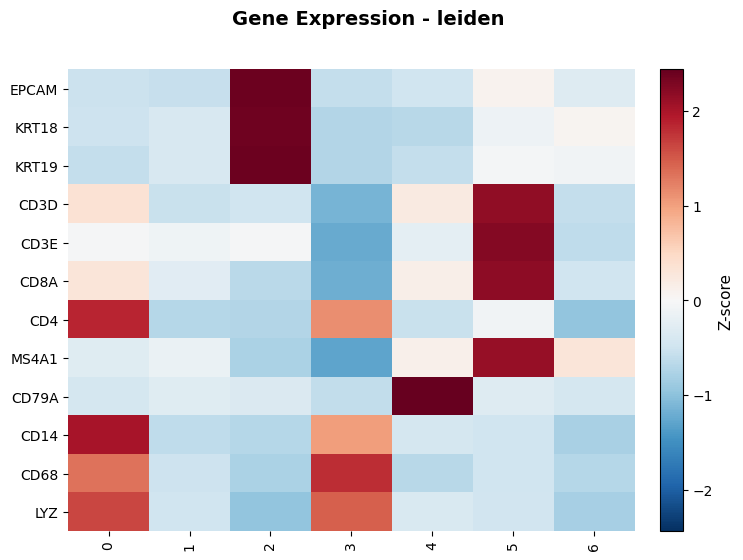

In [22]:
# Order genes by cell type
gene_order = [
    # Epithelial
    'EPCAM', 'KRT18', 'KRT19',
    # T cells
    'CD3D', 'CD3E', 'CD8A', 'CD4',
    # B cells
    'MS4A1', 'CD79A', 'CD79B',
    # Myeloid
    'CD14', 'CD68', 'LYZ'
]

# Order clusters
custom_order = [str(i) for i in range(len(sp._cell_meta.leiden.unique()))]

sj.visualization.plot_heatmap(
    sp,
    genes=gene_order,
    group_by='leiden',
    gene_order=gene_order,
    group_order=custom_order,
    scale='row',
    show=False,
    layer='log_normalized'
)

In [23]:
sj.processing.magic_impute(
    sp,
    layer='log_normalized',
    conda_env='magic_env',  # Use the conda environment we created
    knn=5,                  # Number of nearest neighbors (3-10 typical)
    t=3,                    # Diffusion time steps (2-4 typical)
    n_pca_components=100,   # PCA components for k-NN graph
    output_layer='magic_imputed',
    inplace=True
)


MAGIC imputation (knn=5, t=3)
  Running MAGIC in conda environment: 'magic_env'
    Calling conda environment 'magic_env'...
Input shape: (25368, 960)
n_pca: 100, knn: 5, t: 3
Building k-NN graph...
Running MAGIC diffusion...
Calculating MAGIC...
  Running MAGIC on 25368 cells and 960 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.82 seconds.
    Calculating affinities...
    Calculated affinities in 1.09 seconds.
  Calculated graph and diffusion operator in 2.78 seconds.
  Calculating imputation...
  Calculated imputation in 1.94 seconds.
Calculated MAGIC in 4.73 seconds.
MAGIC imputation complete!
Output shape: (25368, 960)


  ✓ MAGIC imputation complete
✓ Added layer 'magic_imputed' (dense, 185.8 MB)


In [27]:
print("Layers are below:")
for i in sp.list_layers():
    print(f"matrix:{i}")


Layers are below:
matrix:normalized_counts
matrix:log_normalized
matrix:scaled
matrix:magic_imputed


/carc/scratch/projects/amitra2016502/spatioloji_s/src/spatioloji_s/visualization/basic_plots.py:1548: UserWarning: 1 gene(s) not found in dataset and will be skipped: ['CD79B']
  warnings.warn(


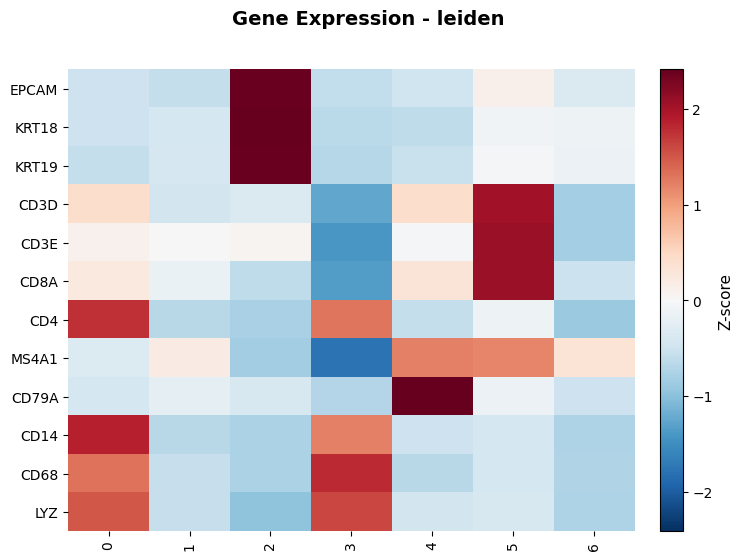

In [28]:
# Order genes by cell type
gene_order = [
    # Epithelial
    'EPCAM', 'KRT18', 'KRT19',
    # T cells
    'CD3D', 'CD3E', 'CD8A', 'CD4',
    # B cells
    'MS4A1', 'CD79A', 'CD79B',
    # Myeloid
    'CD14', 'CD68', 'LYZ'
]

# Order clusters
custom_order = [str(i) for i in range(len(sp._cell_meta.leiden.unique()))]

sj.visualization.plot_heatmap(
    sp,
    genes=gene_order,
    group_by='leiden',
    gene_order=gene_order,
    group_order=custom_order,
    scale='row',
    show=False,
    layer='magic_imputed'
)

In [29]:
os.makedirs("my_data_objects")
sp.to_pickle("my_data_objects/run_workflow_impute_spatioloji.pickle")


Saving spatioloji to: my_data_objects/run_workflow_impute_spatioloji.pickle
✓ Saved (834.3 MB)
